In [1]:
#Importation des librairies 
import umap
import umap.plot
from sklearn.cluster import DBSCAN
import warnings
import hdbscan
import seaborn as sns
from sklearn_extra.cluster import KMedoids
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn import decomposition
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# Pour les biplot
from bioinfokit.visuz import cluster
from IPython import display
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import  PowerTransformer
from scipy import stats
from sklearn.preprocessing import  QuantileTransformer
pt = PowerTransformer()
qt = QuantileTransformer(output_distribution='normal')
#import matplotlib.pyplot as plt3D
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)
warnings.filterwarnings('ignore')
import datetime
sns.set(style='white', context='notebook', rc={'figure.figsize': (8, 6)})


Les paragraphes suivants décrivant UMAP sont tirées de l'article original disponible sur ce lien : https://arxiv.org/pdf/1802.03426.pdf

UMAP : Uniform Manifold Approximation and Projection (UMAP) est une technique de réduction de dimension qui peut être utilisée pour la visualisation de la même manière que t-SNE, mais aussi pour la réduction de dimension non linéaire générale. L'algorithme est fondé sur trois hypothèses concernant les données

* Les données sont uniformément distribuées sur la variété riemannienne
* La métrique riemannienne est localement constante (ou peut être approchée comme telle) ;
* Le collecteur est connecté localement.

A partir de ces hypothèses, il est possible de modéliser la variété avec une structure topologique floue. L'intégration est trouvée en recherchant une projection de faible dimension des données qui a la structure topologique floue équivalente la plus proche possible.

Astuce UMAP pour l'utiliser comme entrée dans un modèle de clustering
* Lorsque vous utilisez UMAP pour la réduction de dimension, vous souhaiterez sélectionner des paramètres différents de ceux que vous utiliseriez pour la visualisation. 
* Nous voudrons une  n_neighbors  valeur plus grande - les petites valeurs se concentreront davantage sur une structure très locale et sont plus susceptibles de produire une structure de cluster à grain fin qui peut être davantage le résultat de modèles de bruit dans les données que de clusters réels. Dans ce cas, nous allons le doubler de la valeur par défaut de 15 à 30.
* Deuxièmement, il est avantageux de définir min_dist  une valeur très faible. Étant donné que nous voulons en fait regrouper les points de manière dense(la densité est ce que nous voulons après tout), une valeur faible aidera, ainsi que des séparations plus nettes entre les clusters. Dans ce cas, nous allons simplement définir min_distà 0.

Limites :
* Comme pour la plupart des techniques de réduction de dimension non linéaires (y compris t-SNE et Isomap), UMAP n'a pas le fort
interprétabilité de l'analyse en composantes principales (ACP) et des techniques connexes telles que la factorisation matricielle non négative (NMF). En particulier 
les dimensions de l'espace d'intégration UMAP n'ont pas de signification spécifique, contrairement à l'ACP où les dimensions sont les directions de plus grande variance dans
les données sources

In [2]:
data_full = pd.read_csv(
    "/Users/anis/test_labnbook/test_3_indicateurs/comparaison/data.csv")
data_full.drop(["Unnamed: 0"], axis=1, inplace=True)

# Supprimer les labdocs ayant un score de contribution nul
data_full.drop(index=data_full[data_full["equi_contrib"]
               == 0].index.values, axis=0, inplace=True)

#data_full.drop(["n_users", "n_modif",	"duree",  "n_mots"], axis=1, inplace=True)
data_full.drop(index=data_full[data_full["collab"]
               < 0].index.values, inplace=True)

data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16267 entries, 0 to 17506
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id_labdoc     16267 non-null  int64  
 1   n_users       16267 non-null  int64  
 2   n_mots        16267 non-null  int64  
 3   collab        16267 non-null  float64
 4   equi_contrib  16267 non-null  float64
 5   n_modif       16267 non-null  int64  
 6   duree         16267 non-null  float64
 7   pass_main     16267 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 1.1 MB


In [3]:
data_full.head()

,id_labdoc,n_users,n_mots,collab,equi_contrib,n_modif,duree,pass_main
0,313544,3,67,0.086970,0.089902,13,1934637.0,3
1,325259,2,180,0.616471,0.947732,64,215938.0,1
2,313676,3,110,0.035226,0.036662,66,1818387.0,1
3,313555,3,152,0.066678,0.069033,9,1933760.0,1
4,312700,5,38,0.555177,0.555177,18,2278994.0,6


In [4]:
#sns.heatmap(data_full.corr(),annot=True)

In [5]:

# J'enlève la variable n_users
X = data_full.drop([ "n_users","pass_main"], axis=1)


#X.index = np.array(data['id_labdoc'])
id_labdoc = data_full['id_labdoc']
X.drop(['id_labdoc'], axis=1, inplace=True)

# z_scores = stats.zscore(X)
# abs_z_scores = np.abs(z_scores)
# filtered_entries = (abs_z_scores < 3).all(axis=1)
# X = X[filtered_entries]
# X.info()

X.head()

,n_mots,collab,equi_contrib,n_modif,duree
0,67,0.086970,0.089902,13,1934637.0
1,180,0.616471,0.947732,64,215938.0
2,110,0.035226,0.036662,66,1818387.0
3,152,0.066678,0.069033,9,1933760.0
4,38,0.555177,0.555177,18,2278994.0


In [6]:
data= X.copy()

pt_trans = ["n_modif", "n_mots",]
for _,c in enumerate(pt_trans):
    data.loc[:, c] = pt.fit_transform(np.array(data[c]).reshape(-1, 1))
    

qt_trans = ["duree", "collab", "equi_contrib"]
for _, c in enumerate(qt_trans):
    data.loc[:, c] = qt.fit_transform(np.array(data[c]).reshape(-1, 1))

#scaler = StandardScaler()
#data= pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

<AxesSubplot:>

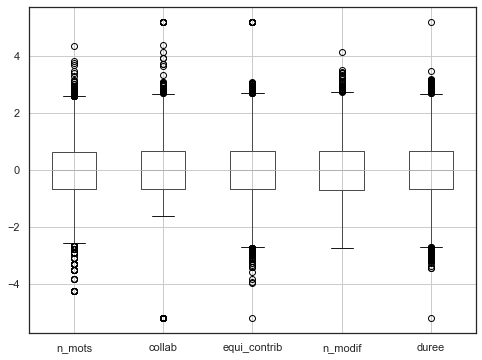

In [7]:
data.boxplot()

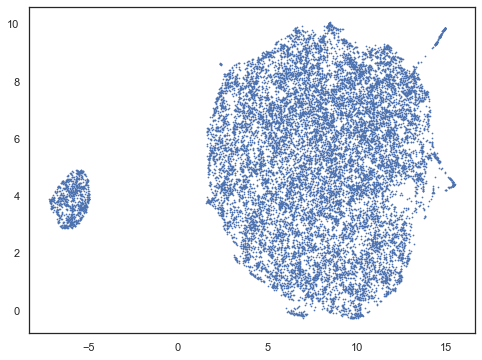

In [8]:
# for n in (2, 5, 10, 20, 50, 100, 200):
#     for d  in (.0, .25 , .5 , .75 , .99 ):
#         standard_embedding = umap.UMAP(random_state=42, n_neighbors=n, min_dist =d).fit_transform(data)
#         plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], s=0.5, cmap='Spectral')
#         plt.title("n_neighbors {} min_dist {}".format(n,d))
#         plt.show()
standard_embedding = umap.UMAP(
    random_state=42).fit_transform(data)
plt.scatter(standard_embedding[:, 0],
            standard_embedding[:, 1], s=0.5, cmap='Spectral')
plt.show()

In [9]:
clusterable_embedding = umap.UMAP(
    random_state=42, n_neighbors=30, min_dist=0).fit_transform(data)


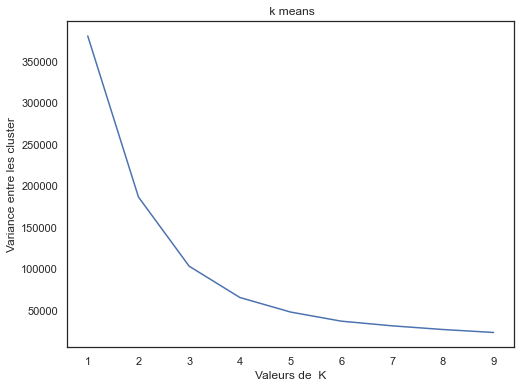

In [10]:
#Trouver le meilleur K
Sum_of_squared_distances = []
K = range(1,10 )
for num_clusters in K:
    model = KMeans(n_clusters=num_clusters)
    model.fit(clusterable_embedding)
    Sum_of_squared_distances.append(model.inertia_)
plt.plot(K, Sum_of_squared_distances)
plt.xlabel('Valeurs de  K')
plt.ylabel('Variance entre les cluster')
plt.title(' k means')
plt.show()


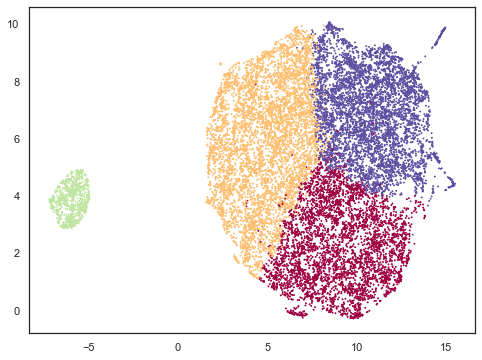

In [11]:
n_clusters = 4
kmeans_labels = KMeans(n_clusters=n_clusters).fit_predict(
    clusterable_embedding)
plt.scatter(standard_embedding[:, 0], standard_embedding[:,
            1], c=kmeans_labels, s=0.8, cmap='Spectral')


In [12]:
data_final = data_full.copy()
data_final["labels"] = kmeans_labels

gb = data_final[["n_users",	"n_mots",	"collab",	"equi_contrib",	"n_modif",	"duree",	"pass_main"]].groupby(
    kmeans_labels)
result = pd.DataFrame(gb.mean())
result["freq %"] = gb.size() / np.shape(data_final)[0] * 100
result.append(data_final[["n_users",	"n_mots",	"collab",	"equi_contrib",
              "n_modif",	"duree",	"pass_main"]].mean(), ignore_index=True)
# La dernière ligne est la moyenne sur tout le dataset 

,n_users,n_mots,collab,equi_contrib,n_modif,duree,pass_main,freq %
0,2.182214,156.834747,0.096824,0.147400,33.069906,273719.721293,1.669952,26.821172
1,2.244880,66.557675,0.511423,0.656710,18.252757,121409.345178,1.651147,35.120182
2,2.110718,136.494700,0.000000,0.670087,25.475854,235525.335689,1.408716,5.219155
3,2.443841,357.326844,0.270956,0.649711,75.004867,583744.704792,2.798765,32.839491
4,2.286408,189.908281,0.294563,0.518507,41.240979,320045.242270,2.020409,NaN


* Cluster 0 : très petit labdocs , forte contribution et forte collaboration (Construction séquentielle intégrative)
* Cluster 1 : petit labdocs, forte contribution et très faible collaboration (Construction séquentielle sommative) 
* Cluster 2 : moyen labdocs, faible contribution et faible collaboration (pas de collaboration, le document est rédigé par une minorité)
* Cluster 3 : grand labdocs, forte contribution et collaboration moyenne (entre les deux stratégies séquentielles, sommative et intégrative)

In [13]:
# for i in np.array(result['n_modif']):
#     print(str(datetime.timedelta(seconds=i*20)))

# str(datetime.timedelta(seconds=320045.242270))


In [14]:
# # pour chaque n_user : nombre n_user dans le cluster / nombre total de n_user
# n_users_total = pd.DataFrame([data_full[kmeans_labels == i].groupby(
#     "n_users").size() / data_full.groupby("n_users").size() * 100 for i in range(n_clusters)])
# n_users_total

In [15]:
# pour chaque n_user : nombre n_user dans le cluster / nombre total de n_user dans le cluster)

n_users_cluster = pd.DataFrame([data_full[kmeans_labels == i].groupby(
    "n_users").size() / data_full.groupby(
    kmeans_labels).size()[i] * 100 for i in range(n_clusters)])
n_users_cluster

n_users,2,3,4,5,6,7,8
0,83.680953,14.714646,1.398121,0.137520,0.045840,0.022920,NaN
1,78.050061,20.357080,1.102748,0.245055,0.087520,0.105024,0.052512
2,89.517079,9.893993,0.588928,NaN,NaN,NaN,NaN
3,67.615125,24.466492,5.110446,1.853238,0.673905,0.243355,0.037439


In [16]:
# pour chaque pass_main : nombre pass_main dans le cluster / nombre total de pass_main dans le cluster)
pass_main_cluster = pd.DataFrame([data_full[kmeans_labels == i].groupby(
    "pass_main").size() / data_full.groupby(
    kmeans_labels).size()[i] * 100 for i in range(n_clusters)])
pass_main_cluster


pass_main,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,25,27,29
0,58.652303,26.449691,8.892964,3.392161,1.512721,0.573000,0.229200,0.183360,0.068760,0.022920,NaN,0.022920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,62.208997,22.912655,8.436898,3.553299,1.312795,0.717661,0.542622,0.175039,0.017504,0.087520,0.017504,NaN,NaN,NaN,0.017504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,73.733804,17.785630,5.653710,1.413428,0.588928,0.471143,NaN,0.117786,0.117786,0.117786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,33.414452,26.151254,15.387495,9.715462,5.428678,3.556720,1.928117,1.123175,1.048297,0.673905,0.505429,0.168476,0.262074,0.149757,0.037439,0.168476,0.093598,0.01872,0.056159,0.037439,0.01872,0.01872,0.01872,0.01872


|                                     | Cluster 0                | Cluster 1              | Cluster 3                                    | Cluster 2            | Moyenne (total)  |
|-------------------------------------|--------------------------|------------------------|----------------------------------------------|----------------------|------------------|
| Taille du cluster (freq.)           | 35.06 %                  | 5.21%                  | 32.80 %                                      | 26.91 %              | --------------   |
| Taille des labdocs (nbr. mots)      | très petit (66)          | petit (136)            | grand labdocs (357)                          | moyen (156)          | 190 mots         |
| Collaboration                       | forte (0.512)            | nulle (0.00)           | moyenne (0.27)                               | faible (0.097)       | 0.294            |
| équilibre de contribution           | fort (0.65)              | forte (0.67)           | fort (0.65)                                  | faible (0.15)        | 0.518            |
| passage de main                     | 1.65                     | 1.40                   | 2.79                                         | 1.66                 | 2.02             |
| fréquence passage de main  dominant | 1 et 2                   | 1 et 2                 | 1,2 et 3                                     | 1 et 2               | --------------   |
| fréquence d'utilisateur dominant    | 2 et 3                   | 2 et 3                 | 2 et 3                                       | 2 et 3               | --------------   |
| Durée moyenne                       | 1 day, 9:44:13           | 2 days, 17:25:25       | 6 days, 18:18:14                             | 3 days, 3:51:42      | 3 days, 16:54:05 |
| Temps d'édition (n_modifs*20)       | 0:06:04.751052           | 0:08:29.517079         | 0:25:00                                      | 0:11:02              | 0:13:44          |
| Stratérie de contruction du labdoc  | séquentielle intégrative | séquentielle sommative | entre séquentielle, sommative et intégrative | Pas de collaboration | ---------------- |

In [18]:
# from mpl_toolkits import mplot3d
# import numpy as np
# import matplotlib.pyplot as plt


# for d  in (.0, .25, .5 , .75 , .99 ) :
#     for n in (2, 5, 10, 20, 50, 100, 200):
#         fig = plt.figure(figsize=(10, 7))
#         ax = plt.axes(projection="3d")
#         standard_embedding = umap.UMAP(random_state=42, n_neighbors=n, min_dist =d,n_components=3).fit_transform(data)
#         ax.scatter3D(standard_embedding[:, 0], standard_embedding[:, 1], standard_embedding[:, 2])
#         plt.title("n_neighbors {} min_dist {}".format(n,d))
#         plt.show()


In [21]:
data_final


,id_labdoc,n_users,n_mots,collab,equi_contrib,n_modif,duree,pass_main,labels
0,313544,3,67,0.086970,0.089902,13,1934637.0,3,0
1,325259,2,180,0.616471,0.947732,64,215938.0,1,3
2,313676,3,110,0.035226,0.036662,66,1818387.0,1,0
3,313555,3,152,0.066678,0.069033,9,1933760.0,1,0
4,312700,5,38,0.555177,0.555177,18,2278994.0,6,1
...,...,...,...,...,...,...,...,...,...
17502,424605,2,170,0.076776,0.817215,32,117420.0,1,3
17503,424607,2,76,0.162382,0.416134,7,24657.0,1,1
17504,424598,2,89,0.028818,0.028980,34,102424.0,3,0
17505,424612,2,132,0.070637,0.970124,37,1306.0,2,3


In [19]:
data_final.to_excel(
    "/Users/anis/test_labnbook/test_3_indicateurs/comparaison/data_final_kmeans.xlsx")
data_final.to_csv(
    "/Users/anis/test_labnbook/test_3_indicateurs/comparaison/data_final_kmeans.csv")


In [22]:
10/35

0.2857142857142857

In [23]:
1/3

0.3333333333333333

In [24]:
(0.6394 + 0.672)/3


0.4371333333333333